# TDA- ALPHA COMPLEX TEST
Topological data analysis on two and three dimensional synthetic data sets

In [1]:
library(TDA)
library(repr)
library(stringr)
library("scatterplot3d")
synthetic1 = read.csv(file="Practice2DTDA_1.csv", head=FALSE)
library("ripserr")

library(R.matlab)
library(ggplot2)
library(pracma)
library(RColorBrewer)
library(lattice)

library(grid)
library(graphics)

library(extrafont)
library(latex2exp)

library("ripserr")


Welcome to ripserr.
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen



ERROR: Error in library(extrafont): there is no package called ‘extrafont’


In [2]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/dbhaskar92/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

In [3]:
px2um = 1.0

dim0barcode = function(dimintervals, max_x_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0, 1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    g = g + geom_point(aes(x = bmat, y = ymat), color = "darkblue", size = 2.25)
    g = g + geom_point(aes(x = dmat, y = ymat), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                         color = "darkblue", size = 1.25)
    
    # last connected component
    g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 1.25)
    
    g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23), 
                 axis.text.x = element_text(colour = "black", size = 20))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

dim1barcode = function(dimintervals, x_min_lim, x_max_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0,1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    g = g + geom_point(aes(x = bmat, y = ymat), color = 'red', size = 2.25)
    g = g + geom_point(aes(x = dmat, y = ymat), color = 'red', size = 2.25)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat),
                         color = 'red', size = 1.25)
    
    g = g + ylab(TeX('$\\beta_1$')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(x_min_lim, x_max_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23), 
                 axis.text.x = element_text(colour = "black", size = 20))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = px2um * dim1intervals[,2]
        d1mat = px2um * dim1intervals[,3]

        g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 2.25)
        g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 2.25)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 1.25)
    }
    
    b0mat = px2um * dim0intervals[,2]
    d0mat = px2um * dim0intervals[,3]
    
    g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 2.25)
    g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 1.25)
    
    # last connected component
    g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 2.5)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 1.25)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23), 
                 axis.text.x = element_text(colour = "black", size = 20))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = px2um * dim0intervals[,2]
    beta0_dmat = px2um * dim0intervals[,3]
    
    beta1_bmat = px2um * dim1intervals[,2]
    beta1_dmat = px2um * dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 2.5, stroke = 1.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 2.5, stroke = 1.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 1.25)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 23),
                axis.text.x = element_text(colour = "black", size = 20), 
                axis.text.y = element_text(colour = "black", size = 20))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    p
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

# Practice with Barcode for a single circle
This data is from the KDE estimation method (mostly for practice in R)

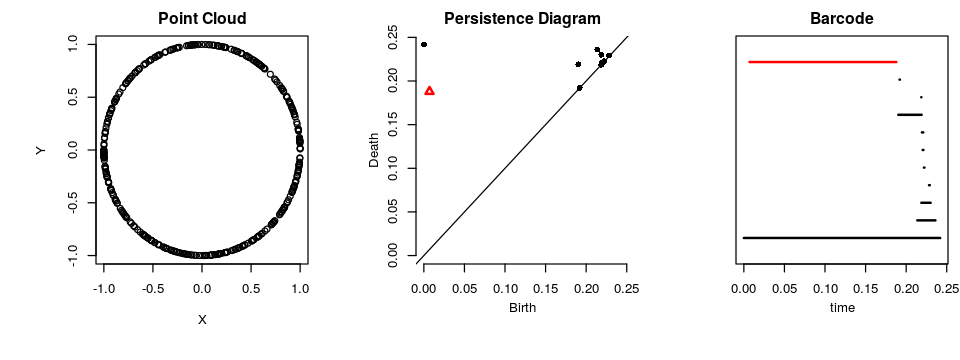

In [4]:
X <- circleUnif(400)
Xlim <- c(-1.6, 1.6); Ylim <- c(-1.7, 1.7); by <- 0.065
Xseq <- seq(Xlim[1], Xlim[2], by = by)
Yseq <- seq(Ylim[1], Ylim[2], by = by)
DiagGrid <- gridDiag(X = X, FUN = kde, h = 0.3, lim = cbind(Xlim, Ylim), by = by, sublevel = FALSE, library = 'PHAT', location = TRUE, printProgress = FALSE)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(X, xlab="X", ylab="Y", main = "Point Cloud")
plot(DiagGrid[["diagram"]], main = "Persistence Diagram")
plot(DiagGrid[["diagram"]], barcode = TRUE, main = "Barcode")

# Practice with the VR Complex data and results
Data generated from a two circles, the first centered at zero and the second larger and shifted

In [46]:
Circle1 = circleUnif(60)
Circle2 = circleUnif(60,r=2)+3
Circle3 = circleUnif(60,r=0.8)+3
Circles = rbind(Circle1,Circle2,Circle3)

maxscale = 5 #limits the scale of which features will be searched for
maxdimension = 1 #connected components and loops!

DiagRips <- ripsDiag(X = Circles, maxdimension, maxscale, library = c("PHAT"), location = TRUE, printProgress = FALSE)

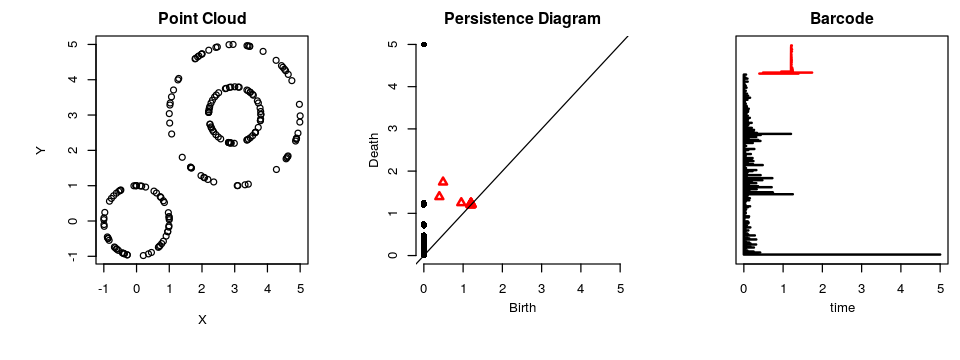

In [47]:
#plot the data
scalefactor = 3
options(repr.plot.width=scalefactor,repr.plot.height=scalefactor)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

#plot a barcode
plot(Circles, xlab="X", ylab="Y", main = "Point Cloud")
plot(DiagRips[["diagram"]], main = "Persistence Diagram")
plot(DiagRips[["diagram"]],barcode = TRUE, main = "Barcode")

# Synthetic Data 1.1
Now we will attempt to extract topological parameters from the synthetic data sets. Level 3, 3 clusters.

In [63]:
#import and transpose synthetic data
z = data.matrix(synthetic1)
z = t(z)
#truncate the data to a more manageable size
z = z[seq(1,3000,10),1:2]

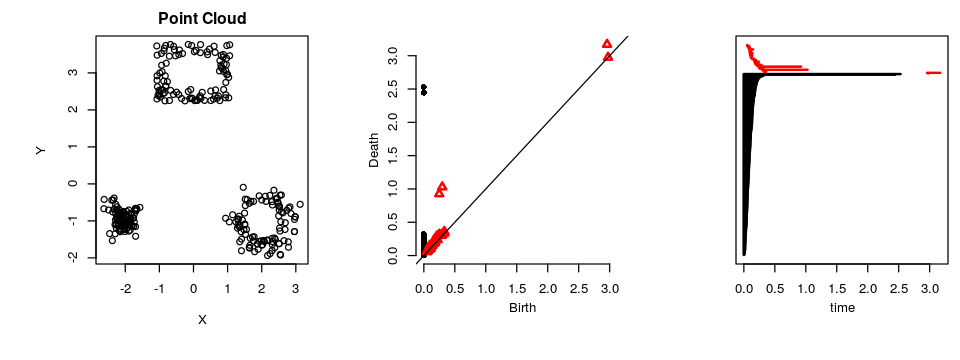

In [64]:
#extract topological features

maxscale = 10 #limits the scale of which features will be searched for
maxdimension = 1 #connected components and loops!

#DiagRips <- ripsDiag(X = z, maxdimension, maxscale, library = c("PHAT"), location = TRUE, printProgress = FALSE)

homology_z1 <- ripserDiag(z, maxdimension, maxscale)


par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_z1, barcode = FALSE)
TDA::plot.diagram(homology_z1, barcode = TRUE)

In [65]:
intervals = as.data.frame(homology_z1)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]
p1 = dim0barcode(dim0, 15)
p2 = dim1barcode(dim1, 5, 18)
p3 = persistencediag(dim0, dim1, 18)
p4 = combinedbarcode(dim0, dim1, 18)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

ERROR: Error in TeX("$\\beta_0$"): could not find function "TeX"


In [38]:
a0 = homology_z1[homology_z1[,0]==1,2:3]
a1 = homology_z1[homology_z1[,1]==1,2:3]

In [41]:
qq = combinedbarcode(a0,a1,5)

ERROR: Error in dim1intervals[, 3]: subscript out of bounds


# Synthetic Data 1.1
Now we will attempt to extract topological parameters from the synthetic data sets. Level 3, 5 clusters.

In [37]:
#import and modify the synthetic data for processing
synthetic35 = read.csv(file="Practice2DTDA_35.csv",head=FALSE)
z35 = data.matrix(synthetic35)
z35 = t(z35)

In [38]:
#extract topological features

maxscale = 5 #limits the scale of which features will be searched for
maxdimension = 1 #connected components and loops!

DiagRips35 <- ripsDiag(X = z35, maxdimension, maxscale, library = c("GUDHI"), location = TRUE, printProgress = FALSE)

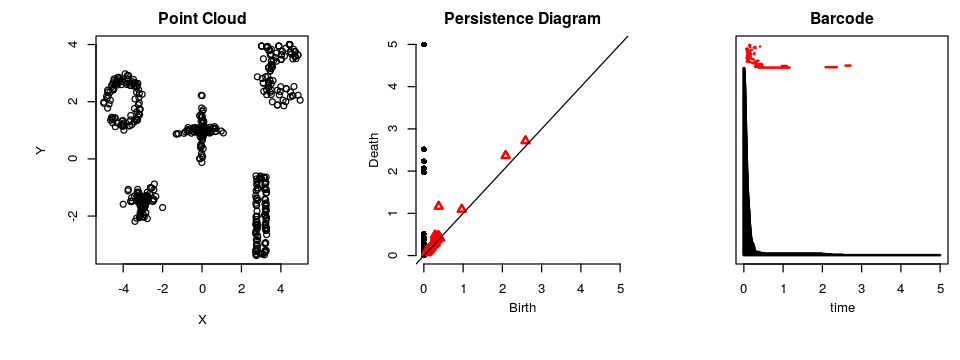

In [39]:
par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z35, xlab="X", ylab="Y", main = "Point Cloud")
plot(DiagRips35[["diagram"]], main = "Persistence Diagram")
plot(DiagRips35[["diagram"]], barcode = TRUE, main = "Barcode")

# Synthetic Data 2.0
3D data implementation, simple sphere

In [3]:
#import and modify the synthetic data for processing
syntheticSph = read.csv(file="Practice3DTDA_Sph.csv",head=FALSE)
zSph = data.matrix(syntheticSph)

In [17]:
#extract topological features

maxscale = 5 #limits the scale of which features will be searched for
maxdimension = 2 #connected components and loops!

DiagRipsSph <- ripsDiag(X = zSph, maxdimension, maxscale, library = c("GUDHI"), location = TRUE, printProgress = FALSE)

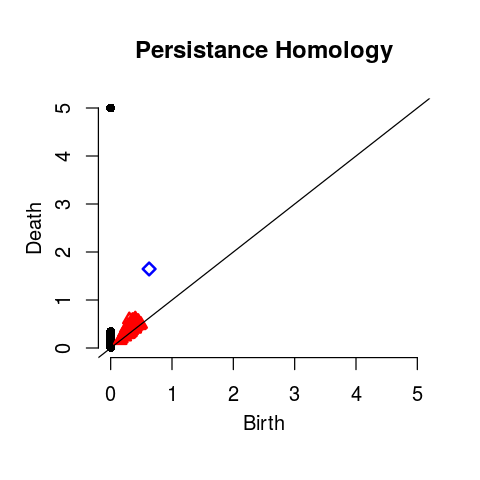

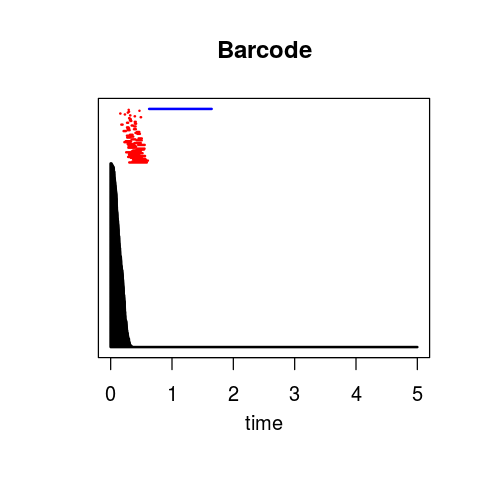

In [24]:
#plot the data
scalefactor = 4
options(repr.plot.width=scalefactor,repr.plot.height=scalefactor)
#plot for confirmation
#plot3D(zSph(,0),zSph(,1),zSph(,2)

#plot a barcode
plot(DiagRipsSph[["diagram"]], main = "Persistance Homology")
plot(DiagRipsSph[["diagram"]], barcode = TRUE, main = "Barcode")

# Synthetic Data 2.1
Now for a slightly trickier example, three seperated elipsoid objects
(Note, this is not currently functional due to run-time issues)

In [15]:
#import and modify the synthetic data for processing
syntheticSph3 = read.csv(file="Practice3DTDA_Sph3.csv",head=FALSE)
zSph3 = data.matrix(syntheticSph3)

In [12]:
#extract topological features

maxscale = 3 #limits the scale of which features will be searched for
maxdimension = 2 #connected components and loops!

DiagRipsSph3 <- ripsDiag(X = zSph3, maxdimension, maxscale, library = c("GUDHI"), location = FALSE, printProgress = FALSE)

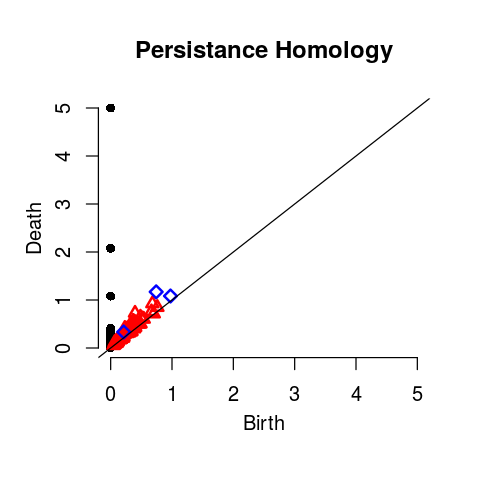

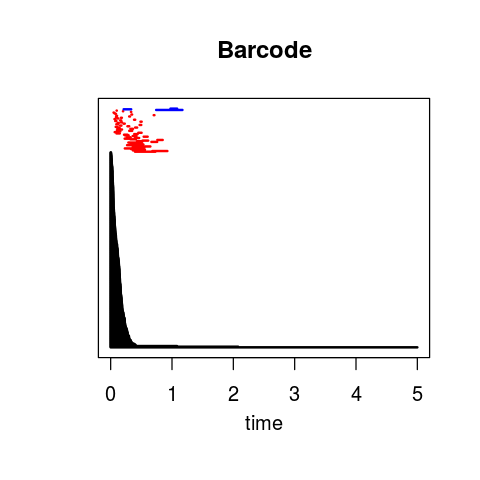

In [7]:
#plot the data
scalefactor = 4
options(repr.plot.width=scalefactor,repr.plot.height=scalefactor)
#plot for confirmation
#plot3D(zSph(,0),zSph(,1),zSph(,2)

#plot a barcode
plot(DiagRipsSph3[["diagram"]], main = "Persistance Homology")
plot(DiagRipsSph3[["diagram"]],barcode = TRUE, main = "Barcode")

# Synthetic Data 2.2
Now for a slightly trickier example, two concentric circles

In [14]:
#import and modify the synthetic data for processing
syntheticSph2 = read.csv(file="Practice3DTDA_Sph2.csv",head=FALSE)
zSph2 = data.matrix(syntheticSph2)

In [2]:
#extract topological features

maxscale = 5 #limits the scale of which features will be searched for
maxdimension = 2 #connected components and loops!

DiagRipsSph2 <- ripsDiag(X = zSph2, maxdimension, maxscale, library = c("GUDHI"), location = FALSE, printProgress = FALSE)

ERROR: Error in ripsDiag(X = zSph2, maxdimension, maxscale, library = c("GUDHI"), : could not find function "ripsDiag"


In [67]:
#plot the data
scalefactor = 4
options(repr.plot.width=scalefactor,repr.plot.height=scalefactor)
#plot for confirmation

#plot a barcode
plot3D(zSph(,0), zSph(,1), zSph(,2))
plot(DiagRipsSph2[["diagram"]], main = "Persistance Homology")
plot(DiagRipsSph2[["diagram"]],barcode = TRUE, main = "Barcode")

ERROR: Error in plot3D(zSph(, 0), zSph(, 1), zSph(, 2)): could not find function "plot3D"


## Ripser binding

In [8]:
library("ripserr")
options(repr.plot.width=4,repr.plot.height=4)

homologyn <- ripserr::ripser(zSph)

TDA::plot.diagram(homologyn, barcode = FALSE)
TDA::plot.diagram(homologyn, barcode = TRUE)

Welcome to ripserr.


ERROR: Error in nrow(mat): object 'zSph' not found


### Use ripser to calculate homology of points on a sphere

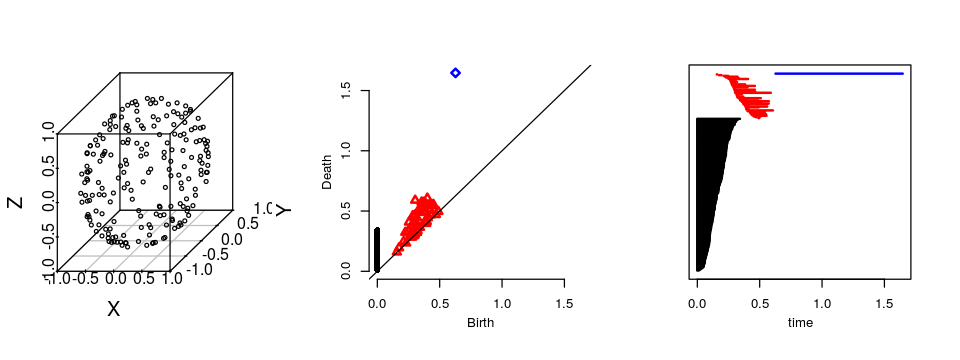

In [45]:
syntheticSph = read.csv(file="Practice3DTDA_Sph.csv",head=FALSE)
zSph = data.matrix(syntheticSph)

homology0_zSph <- ripserDiag(zSph, 0, 5.0)
homology1_zSph <- ripserDiag(zSph, 1, 5.0)
homology2_zSph <- ripserDiag(zSph, 2, 5.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(zSph, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph, barcode = FALSE)
TDA::plot.diagram(homology2_zSph, barcode = TRUE)

### Use ripser to calculate homology of points on two concentric spheres

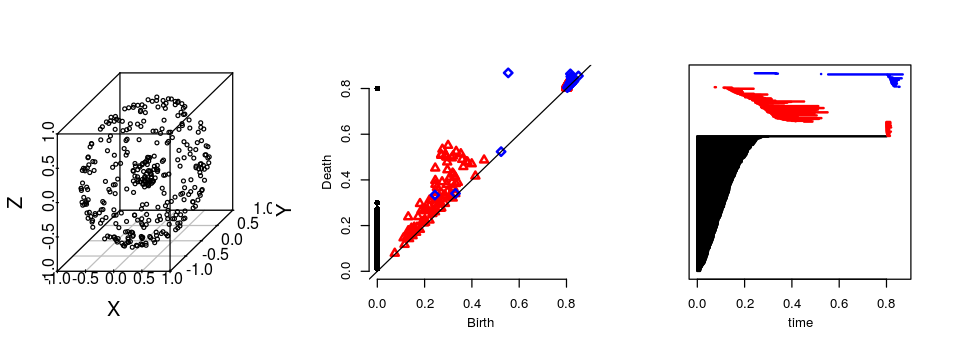

In [46]:
syntheticSph2 = read.csv(file="Practice3DTDA_Sph2.csv",head=FALSE)
zSph2 = data.matrix(syntheticSph2)

homology0_zSph2 <- ripserDiag(zSph2, 0, 10.0)
homology1_zSph2 <- ripserDiag(zSph2, 1, 10.0)
homology2_zSph2 <- ripserDiag(zSph2, 2, 10.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph2, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph2, barcode = FALSE)
TDA::plot.diagram(homology2_zSph2, barcode = TRUE)

### Use ripser to calculate homology of points on three concentric spheres

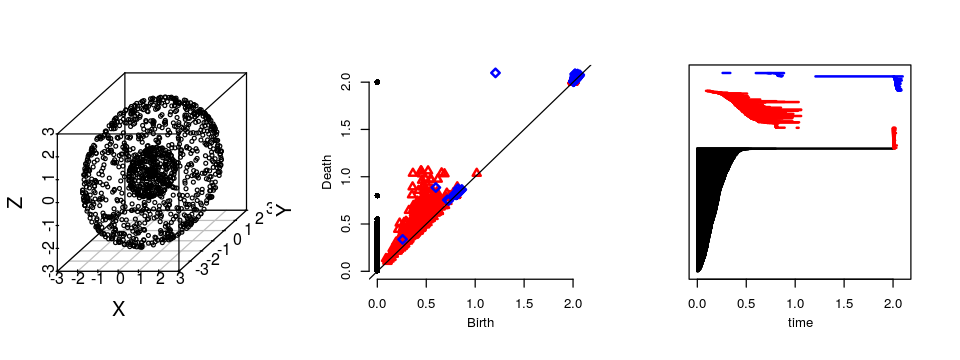

In [47]:
syntheticSPH3 = read.csv(file="Practice3DTDA_Sph3.csv",head=FALSE)
zSph3 = data.matrix(syntheticSPH3)

homology2_zSph3 <- ripserDiag(zSph3, 2, 5)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph3, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph3, barcode = FALSE)
TDA::plot.diagram(homology2_zSph3, barcode = TRUE)

In [27]:
 print(bottleneck(homology0_zSph, homology0_zSph2, dimension = 0))
 print(bottleneck(homology1_zSph, homology1_zSph2, dimension = 1))
 print(bottleneck(homology2_zSph, homology2_zSph2, dimension = 2))

[1] 0.400022
[1] 0.081757
[1] 0.509713


In [32]:
 print(wasserstein(homology0_zSph, homology0_zSph2, dimension = 0,p=2))
 print(wasserstein(homology1_zSph, homology1_zSph2, dimension = 1,p=2))
 print(wasserstein(homology2_zSph, homology2_zSph2, dimension = 2,p=2))

[1] 0.4456591
[1] 0.0899068
[1] 0.2881303


- get alpha on the drawing elements
- silouettes and landscapes, eventually want mean landscape with 95% condiecne band (3.8)

# 3.0 Synthetic Torus data

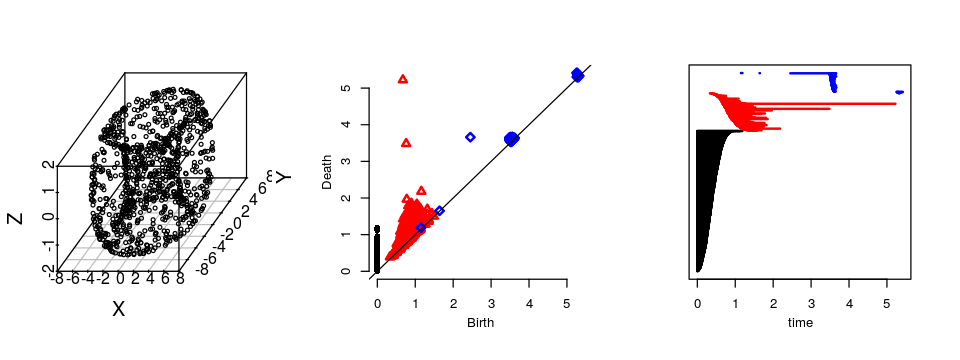

In [48]:
syntheticTorus1 = read.csv(file="Practice3DTDA_Torus2.csv",head=FALSE)
zTorus1 = data.matrix(syntheticTorus1)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

homology2_zTorus1 <- ripserDiag(zTorus1, 2, 10)

scatterplot3d(zTorus1, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zTorus1, barcode = FALSE)
TDA::plot.diagram(homology2_zTorus1, barcode = TRUE)

# 4 Dynamic data of points moving about in a circle. 
## 4.0 Radial Noise Parameter = 0

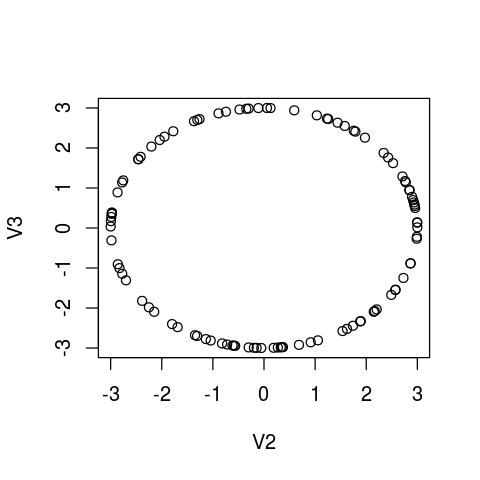

In [5]:
dynamicNoise0 = read.csv(file="Dynamic2DNoise0.csv",head=FALSE)
dyN0 = data.matrix(dynamicNoise0)
dyN0 = dyN0[,2:3]
#options(repr.plot.width=5, repr.plot.height=5)
plot(dyN0)
homology1_dyNo <- ripserDiag(dyN0, 1, 10)

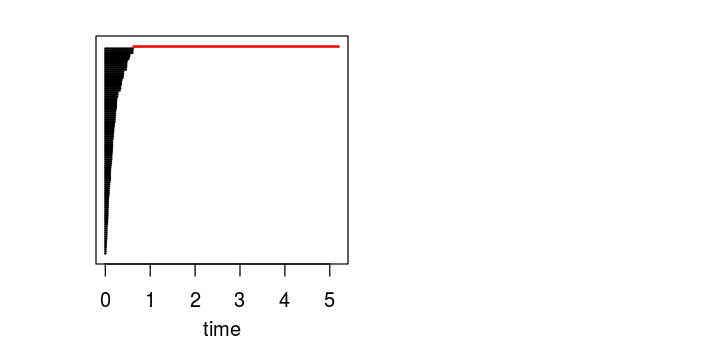

In [6]:
options(repr.plot.width=6,repr.plot.height=3)
par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))

TDA::plot.diagram(homology1_dyNo, barcode = TRUE)

## 4.1 Radial Noise Parameter = 0.1

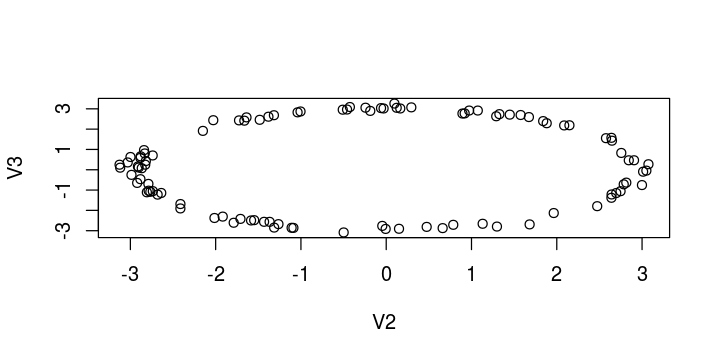

In [7]:
dynamicNoise01 = read.csv(file="Dynamic2DNoise0.1.csv",head=FALSE)
dyN01 = data.matrix(dynamicNoise01)
dyN01 = dyN01[,2:3]
#options(repr.plot.width=5, repr.plot.height=5)
plot(dyN01)
homology1_dyN01 <- ripserDiag(dyN01, 1, 10)

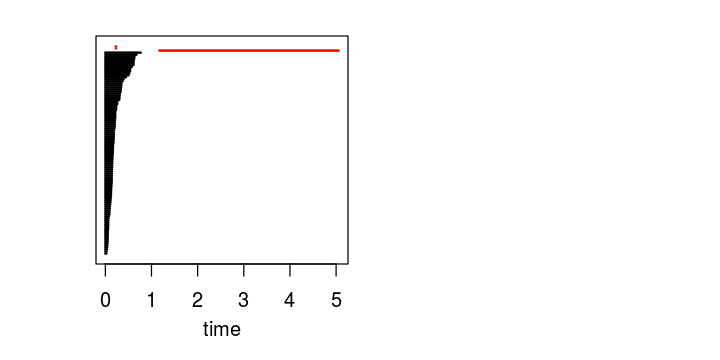

In [8]:
options(repr.plot.width=6,repr.plot.height=3)
par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))

TDA::plot.diagram(homology1_dyN01, barcode = TRUE)

## 4.2 Radial Noise Parameter = 0.3

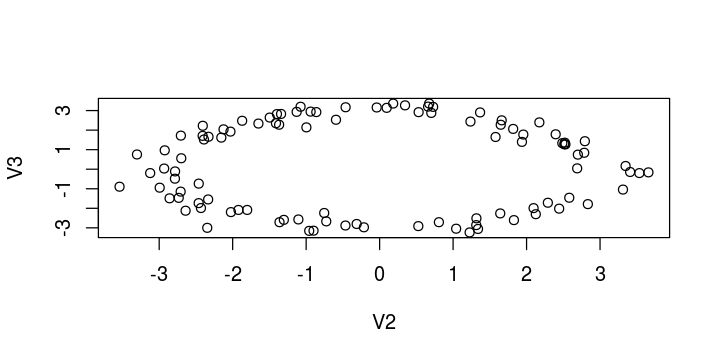

In [32]:
dynamicNoise03 = read.csv(file="Dynamic2DNoise0.3.csv",head=FALSE)
dyN03 = data.matrix(dynamicNoise03)
dyN03 = dyN03[,2:3]
#options(repr.plot.width=5, repr.plot.height=5)
plot(dyN03)
homology1_dyN03 <- ripserDiag(dyN03, 1, 10)

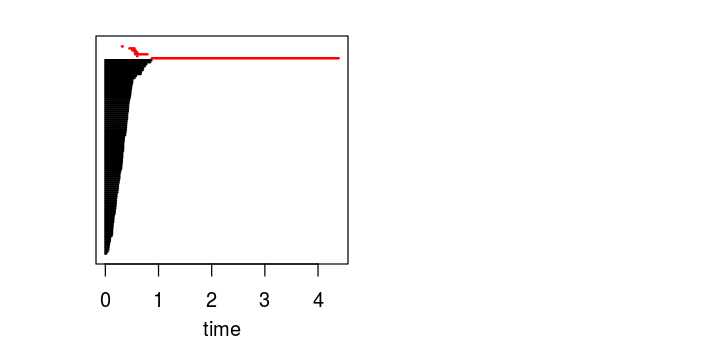

In [34]:
options(repr.plot.width=6,repr.plot.height=3)
par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))

TDA::plot.diagram(homology1_dyN03, barcode = TRUE)

## 4.3 Radial Noise Parameter = 0.7

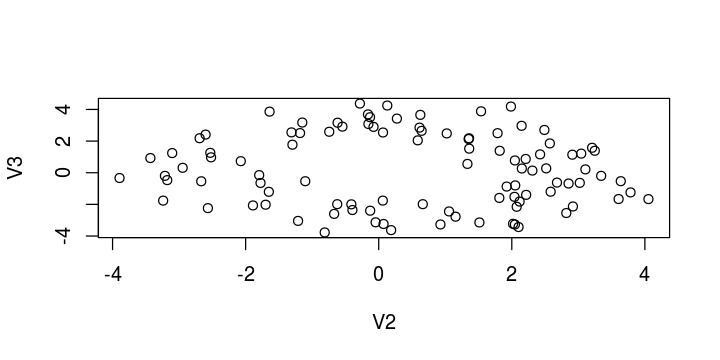

In [35]:
dynamicNoise07 = read.csv(file="Dynamic2DNoise0.7.csv",head=FALSE)
dyN07 = data.matrix(dynamicNoise07)
dyN07 = dyN07[,2:3]
#options(repr.plot.width=5, repr.plot.height=5)
plot(dyN07)
homology1_dyN07 <- ripserDiag(dyN07, 1, 10)

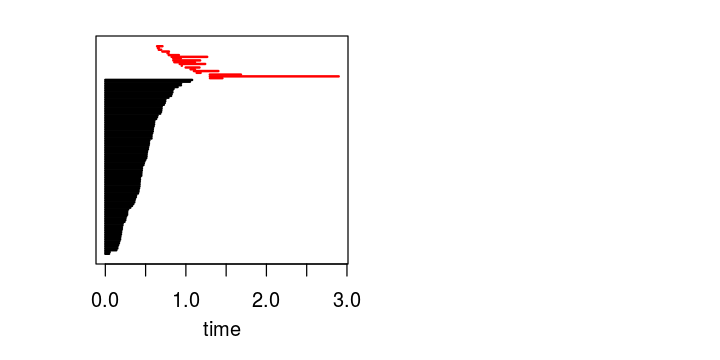

In [36]:
options(repr.plot.width=6,repr.plot.height=3)
par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))

TDA::plot.diagram(homology1_dyN07, barcode = TRUE)

## 4.4 Radial Noise Parameter = 1.2

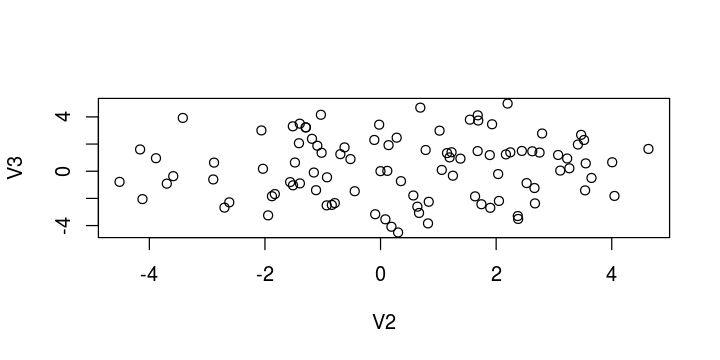

In [9]:
dynamicNoise12 = read.csv(file="Dynamic2DNoise1.2.csv",head=FALSE)
dyN12 = data.matrix(dynamicNoise12)
dyN12 = dyN12[,2:3]
#options(repr.plot.width=5, repr.plot.height=5)
plot(dyN12)
homology1_dyN12 <- ripserDiag(dyN12, 1, 10)

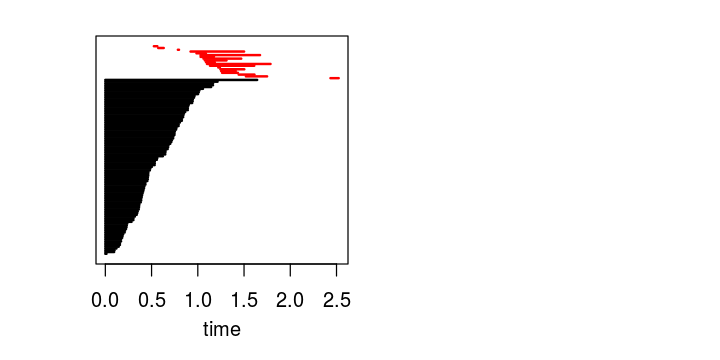

In [10]:
options(repr.plot.width=6,repr.plot.height=3)
par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))

TDA::plot.diagram(homology1_dyN12, barcode = TRUE)